## Imports

In [1]:
%env CUDA_VISIBLE_DEVICES=1

env: CUDA_VISIBLE_DEVICES=1


In [2]:
!echo $CUDA_VISIBLE_DEVICES

1


In [3]:
import torch
import matplotlib.pyplot as plt

In [4]:
import matplotlib
matplotlib.rcParams['figure.facecolor'] = 'white'

In [5]:
# DEVICE = torch.device('cpu')
DEVICE = torch.device('cuda')
DEVICE

device(type='cuda')

## Load data

In [7]:
%run ../datasets/__init__.py

In [49]:
dataset_kwargs = {
    'dataset_name': 'cxr14',
    # 'dataset_name': 'covid-x',
    'dataset_type': 'train',
    'max_samples': None,
    'labels': None, # ['Cardiomegaly'],
}
dataloader = prepare_data_classification(**dataset_kwargs)
dataset = dataloader.dataset
len(dataset)

75714

In [24]:
COVID_SAMPLES = [idx for idx, presence in dataset.get_labels_presence_for('covid') if presence]
len(COVID_SAMPLES)

KeyError: 'covid'

## Load model

In [9]:
%run ../models/checkpoint/__init__.py

In [46]:
# run_name = '0717_120222_covid-x_densenet-121_lr1e-06_os_aug-covid'
# run_name = '0714_030324_covid-x_resnet-50_lr1e-06_os-max14'
# run_name = '0721_214907_cxr14_densenet-121_lr0.001_aug-0_bce_Cardiomegaly_size256'
# run_name = '0721_124730_cxr14_densenet-121_lr1e-05_bce_Cardiomegaly_size256'
# run_name = '1215_174443_cxr14_resnet-50-v2_lr0.0001_os_Cardiomegaly_normS_size256_sch-roc_auc-p5-f0.1'
run_name = '1205_135045_cxr14_mobilenet-v2_lr0.0001_aug_normS_size256_sch-roc_auc-p5-f0.1'
debug = False

In [47]:
compiled_model = load_compiled_model_classification(run_name, debug, DEVICE)
compiled_model.metadata['model_kwargs']

{'model_name': 'mobilenet-v2',
 'labels': ['Atelectasis',
  'Cardiomegaly',
  'Effusion',
  'Infiltration',
  'Mass',
  'Nodule',
  'Pneumonia',
  'Pneumothorax',
  'Consolidation',
  'Edema',
  'Emphysema',
  'Fibrosis',
  'Pleural_Thickening',
  'Hernia'],
 'imagenet': True,
 'freeze': False,
 'gpool': 'avg',
 'fc_layers': []}

In [48]:
_ = compiled_model.model.eval()

## Apply Grad-CAM

### Debug grad-cam correctness

In [92]:
import captum
from captum.attr import LayerGradCam, GuidedGradCam, visualization

In [93]:
%run ../training/classification/grad_cam.py
# %run ../utils/common.py

In [94]:
ACTIVATION = 'sigmoid' if dataset.multilabel else 'softmax'
ACTIVATION

'softmax'

In [95]:
layer = _get_last_layer(compiled_model)

grad_cam_with = LayerGradCam(ModelWrapper(compiled_model.model, activation=ACTIVATION), layer)
grad_cam_wo = LayerGradCam(ModelWrapper(compiled_model.model, activation=None), layer)
# grad_cam = GuidedGradCam(Dummy(model), layer)

In [111]:
LABEL_INDEX = 1

In [112]:
idx = 10

item = dataset[idx]
image = item.image

images = image.unsqueeze(0).to(DEVICE)
images.requires_grad = True
attrs_with = grad_cam_with.attribute(images,
                                     LABEL_INDEX,
                                     relu_attributions=True,
                                    ).detach().cpu().squeeze(0).squeeze(0)
attrs_wo = grad_cam_wo.attribute(images,
                                 LABEL_INDEX,
                                 relu_attributions=True,
                                ).detach().cpu().squeeze(0).squeeze(0)
image.size(), attrs_with.size(), attrs_wo.size()

(torch.Size([3, 512, 512]), torch.Size([16, 16]), torch.Size([16, 16]))

In [113]:
cam_attrs = calculate_cam(compiled_model.model, images)
cam_attrs = cam_attrs.detach().cpu().squeeze(0)[LABEL_INDEX]
cam_attrs.size()

torch.Size([16, 16])

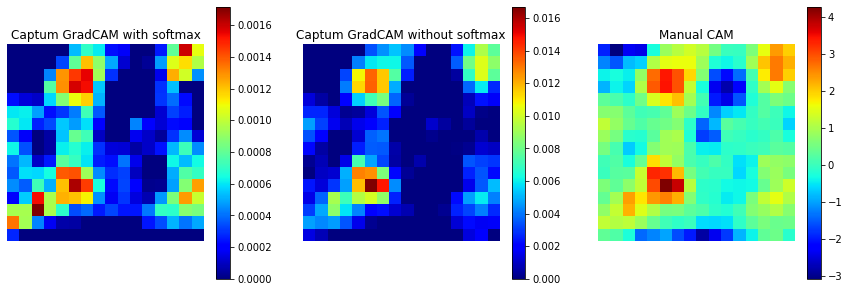

In [114]:
plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
# plt.imshow(tensor_to_range01(image).permute(1, 2, 0))
# plt.title(item.image_fname)
# plt.axis('off')

plt.imshow(attrs_with, cmap='jet')
plt.title(f'Captum GradCAM with {ACTIVATION}')
plt.axis('off')
plt.colorbar()

plt.subplot(1, 3, 2)
plt.imshow(attrs_wo, cmap='jet')
plt.title(f'Captum GradCAM without {ACTIVATION}')
plt.axis('off')
plt.colorbar()

plt.subplot(1, 3, 3)
plt.imshow(cam_attrs, cmap='jet')
plt.title('Manual CAM')
plt.axis('off')
plt.colorbar()

(array([  3.,   7.,  45., 107.,  48.,  18.,   8.,   8.,   6.,   6.]),
 array([-3.0835795 , -2.1882563 , -1.2929332 , -0.39761   ,  0.49771318,
         1.3930364 ,  2.2883596 ,  3.1836827 ,  4.0790057 ,  4.974329  ,
         5.8696523 ], dtype=float32),
 <a list of 10 Patch objects>)

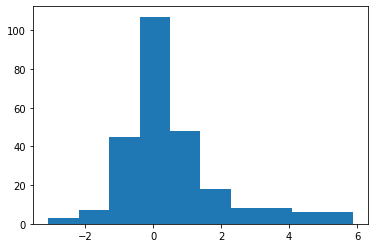

In [108]:
plt.hist((attrs_wo - cam_attrs).view(-1))

### Compute grad-cam

In [13]:
from captum.attr import LayerGradCam, visualization # , GuidedGradCam

from torch import sigmoid
from torch.nn.functional import softmax

In [14]:
%run ../training/classification/grad_cam.py
%run ../utils/common.py

In [15]:
LABEL_INDEX = 0

In [16]:
grad_cam = create_grad_cam(compiled_model, device=DEVICE)

In [48]:
def plot_cam(idx, thresh=0.5, relu=False, **kwargs):
    item = dataset[idx]
    image = item.image
    
    print('Image fname: ', item.image_fname)

    images = image.unsqueeze(0).to(DEVICE)
    # shape: bs=1, 3, height, width

    # Make a prediction
    output = compiled_model.model(images)[0].detach().cpu().squeeze(0)
    # shape: bs=1, n_diseases
    if dataset.multilabel:
        # label_index = item.labels.tolist().index(1)
        label_index = 0
        print('Prediction: ', sigmoid(output[label_index]))
    else:
        print('Prediction: ', softmax(output, dim=-1))
        label_index = item.labels
    print('Ground truth: ', item.labels)

    attributions = calculate_attributions(grad_cam, images, label_index,
                                          relu=relu).detach().cpu().squeeze(0)
    # shape: height, width

    # attributions = attributions.repeat(3, 1, 1).permute(1, 2, 0)
    # shape: height, width, 3
    
    image = tensor_to_range01(image).permute(1, 2, 0)
    # shape: height, width, 3

    # Plot!
    plt.figure(figsize=(15, 5))
    n_subplots = 3
    plt.subplot(1, n_subplots, 1)
    plt.imshow(image)
    plt.axis('off')
    
    plt.subplot(1, n_subplots, 2)
    plt.imshow(attributions, cmap='jet')
    plt.colorbar()
    
    plt.subplot(1, n_subplots, 3)
    plt.imshow(threshold_attributions(attributions, thresh=thresh), cmap='jet')
    plt.colorbar()
    
    
#     visualization.visualize_image_attr_multiple(attributions.numpy(),
#                                                 image.numpy(),
#                                                 methods=['original_image',
#                                                          'blended_heat_map',
#                                                         ],
#                                                 signs=['all', 'all'],
#                                                 titles=['CXR',
#                                                         f'Grad-CAM label={label_index}',
#                                                        ],
#                                                 **kwargs,
#                                                )
    
    return attributions

Image fname:  00000162_000.png
Prediction:  tensor(0.0754)
Ground truth:  [0]


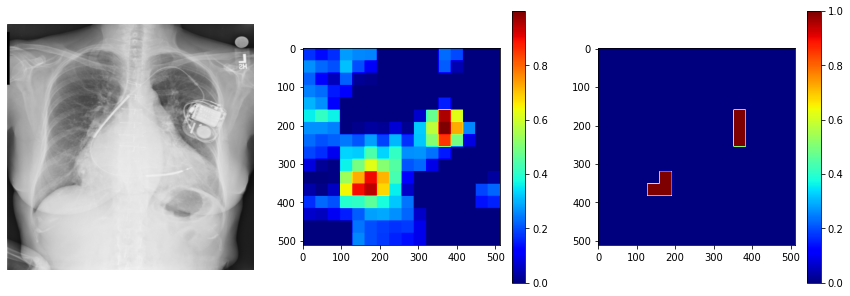

In [83]:
attrs = plot_cam(400, relu=True, thresh=0.8)

Image fname:  00000004_000.png
Prediction:  tensor(0.0002)
Ground truth:  [0]


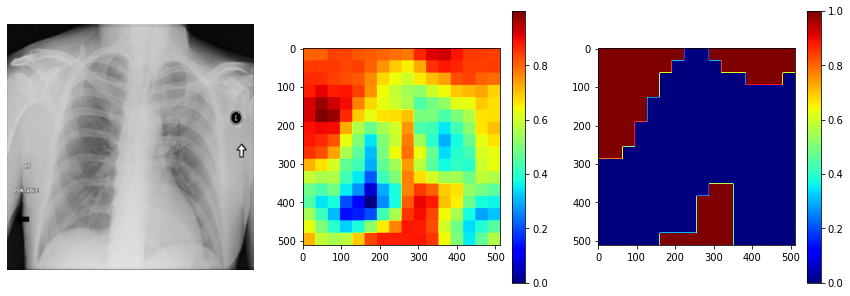

In [58]:
attrs = plot_cam(4, relu=False, thresh=0.8)

### Average over dataset

In [ ]:
from tqdm.notebook import tqdm

In [167]:
mins = []
maxs = []

for idx in tqdm(COVID_SAMPLES): # range(100) # len(dataset)
    image, label = dataset[idx]
    images = image.unsqueeze(0).to(DEVICE)

    attributions = grad_cam.attribute(images, 0)
    attributions = attributions.detach().cpu().squeeze(0).squeeze(0)
    attributions = attributions.numpy()

    mins.append(attributions.min())
    maxs.append(attributions.max())
    
np.mean(mins), np.mean(maxs)

(-2.0381943e-10, 2.047288e-10)

In [ ]:
0: (-2.0381943e-10, 2.047288e-10)
1: (-2.1670395e-10, 2.1722059e-10)
2: (-2.0727114e-10, 2.0217203e-10)